In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.ensemble import GradientBoostingRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import QuantileRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

quantile_estimator_params = {
        "GradientBoostingRegressor": {
            "loss_name": "loss",
            "alpha_name": "alpha"
        },
        "QuantileRegressor": {
            "loss_name": "quantile",
            "alpha_name": "quantile"
        },
        "HistGradientBoostingRegressor": {
            "loss_name": "loss",
            "alpha_name": "alpha"
        },
        "LGBMRegressor": {
            "loss_name": "objective",
            "alpha_name": "alpha"
        },
}

def get_cmap(n, name='Set1'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

# Function needed to run the notebooks

In [2]:
def get_estimator(name, poly_d=10):
    """
    Function to return an estimator.
    """
    random_state = 1
    if name == "GradientBoostingRegressor":
        return GradientBoostingRegressor(loss="quantile", random_state=random_state)
    if name == "QuantileRegressor":
        return QuantileRegressor(solver="highs", alpha=0)
    if name == "polynomial":
        degree_polyn = poly_d
        polyn_model_quant = Pipeline(
            [
                ("poly", PolynomialFeatures(degree=degree_polyn)),
                ("linear", QuantileRegressor(
                        solver="highs",
                        alpha=0,
                ))
            ]
        )
        return polyn_model_quant

def quantile_regression(checked_estimator, X_train, y_train, X_test, y_test, alpha):
    """
    Returns the output of quantile regression.
    """
    if isinstance(checked_estimator, Pipeline):
        estimator = checked_estimator[-1]
    else:
        estimator = checked_estimator
    name_estimator = estimator.__class__.__name__
    alpha_name = quantile_estimator_params[name_estimator]["alpha_name"]
    alphas = [alpha/2, (1 - alpha/2)]
    y_preds = []
    if isinstance(checked_estimator, Pipeline):
        for a in alphas:
            estimator_ = clone(checked_estimator)
            params = {alpha_name: a}
            estimator_[-1].set_params(**params)
            estimator_.fit(X_train, y_train)
            y_preds.append(estimator_.predict(X_test))
    else:
        for a in alphas:
            estimator_ = clone(estimator)
            params = {alpha_name: a}
            estimator_.set_params(**params)
            estimator_.fit(X_train, y_train)
            y_preds.append(estimator_.predict(X_test))
    return y_preds


# Simulated data

To show our results of the analysis we will use the simulated data from the paper by Romano et al. (2020). Note that you can simulate other datasets using the `get_data()` function defined below.

In [3]:
def x_sinx(x, random_state):
    rng = np.random.default_rng(random_state)
    ax = 0*x
    for i in range(len(x)):
        ax[i] = rng.poisson(np.sin(x[i])**2+0.1) + 0.03*x[i]*rng.random()
        ax[i] += 25*(rng.uniform(0, 1, 1) < 0.01)*rng.random()
    return ax.astype(np.float32)

def get_data(funct, n_samples, random_state, random_data=True, random_split=True, noise=0.5, mu=None, sigma=None, min_x=0, max_x=10, data_name=None, test_size=0.3):
    """
    Returns simulated data.
    """
    if random_split:
        random_state_split = random_state
    else: 
        random_state_split = 1
    
    if random_data:
        rng = np.random.default_rng(random_state)
    else: 
        rng = np.random.default_rng(1)
        random_state = 1

    if mu is not None and sigma is not None:
        X_train = rng.normal(mu, sigma, n_samples)
        X_test = np.arange(mu-4*sigma, mu+4*sigma, sigma/20.)
    else:
        X_train = rng.uniform(min_x, max_x, size=n_samples).astype(np.float32)
        X_test = rng.uniform(min_x, max_x, size=n_samples).astype(np.float32)

    y_train, y_test, y_mesh = funct(X_train, random_state=random_state), funct(X_test, random_state=random_state), funct(X_test, random_state=random_state)

    if data_name!="paper_reproduction":
        y_train += rng.normal(0, noise, y_train.shape[0])
        y_test += rng.normal(0, noise, y_test.shape[0])

    if mu is None and sigma is None:
        X_train = np.reshape(X_train, (n_samples, 1))
        X_test = np.reshape(X_test, (n_samples, 1))
    
    X_train_, X_calib_, y_train_, y_calib_ = train_test_split(
        X_train,
        y_train,
        test_size=test_size,
        random_state=random_state_split
    )
    return X_train_, X_calib_, y_train_, y_calib_, X_test, y_test, y_mesh


In [4]:
def CQR_alphas(alphas=0.1, n_samples=1000, iters=0, random_split=True, random_data=False, funct=x_sinx, name_estimator="GradientBoostingRegressor", symmetry=True, add_QR=False):
    """
    Checking what happens when you vary alpha for different types of splits of the dataset.
    """
    if isinstance(n_samples, list) and isinstance(alphas, list):
        raise ValueError("Either n_samples or alphas needs to be a single value.")
    if isinstance(n_samples, int) and isinstance(alphas, float):
        raise ValueError("Either n_samples or alphas needs to be a list.")

    if isinstance(alphas, float):
        name = "n_samples"
        values = n_samples
    else:
        name = "alphas"
        values = alphas

    list_value = []
    
    mapie_coverage = []
    mapie_width = []
    list_scores = []

    initial_coverage = []
    initial_width = []

    if iters>0:
        for i in range(iters):
            lv, mc, mw, ls, ic, iw = CQR_alphas(alphas=alphas, n_samples=n_samples, random_split=random_split, random_data=random_data, funct=funct, name_estimator=name_estimator, symmetry=symmetry, add_QR=add_QR)
            list_value.append(lv)
            mapie_coverage.append(mc)
            mapie_width.append(mw)
            list_scores.append(ls)

            initial_coverage.append(ic)
            initial_width.append(iw)
    else:
        list_value_ = []
        mapie_coverage_ = []
        mapie_width_ = []
        list_scores_ = []

        initial_coverage_ = []
        initial_width_ = []
        random_state = np.random.randint(0, 1000)
        for value in values:
            list_value_.append(value)
            if name == "alphas":
                X_train_, X_calib_, y_train_, y_calib_, X_test, y_test, _ = get_data(funct, n_samples=n_samples, random_state=random_state, random_data=random_data, random_split=random_split, data_name="paper_reproduction")
            else: 
                X_train_, X_calib_, y_train_, y_calib_, X_test, y_test, _ = get_data(funct, n_samples=value, random_state=random_state, random_data=random_data, random_split=random_split, data_name="paper_reproduction")

            estimator = get_estimator(name_estimator)
            if name == "alphas":
                mapie_reg = MapieQuantileRegressor(
                    estimator=estimator,
                    alpha=value,
                )
            else:
                mapie_reg = MapieQuantileRegressor(
                    estimator=estimator,
                    alpha=alphas,
                )
            try: 
                mapie_reg.fit(X_train_, y_train_, X_calib=X_calib_, y_calib=y_calib_)
                y_pred, y_pis, = mapie_reg.predict(X_test, symmetry=symmetry)

                mapie_coverage_.append(regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0]))
                mapie_width_.append(regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0]))
                list_scores_.append(mapie_reg.conformity_scores_)

                if add_QR is True:
                    if name == "alphas":
                        y_pred_qr = quantile_regression(estimator, X_train_, y_train_, X_test, y_test, alpha=value)
                    else:
                        y_pred_qr = quantile_regression(estimator, X_train_, y_train_, X_test, y_test, alpha=alphas)
                    initial_coverage_.append(regression_coverage_score(y_test, y_pred_qr[0], y_pred_qr[1]))
                    initial_width_.append(regression_mean_width_score(y_pred_qr[0], y_pred_qr[1])) 
            except:
                mapie_coverage_.append(np.nan)
                mapie_width_.append(np.nan)
                list_scores_.append(np.nan)
                initial_coverage_.append(np.nan)
                initial_width_.append(np.nan)
        return list_value_, mapie_coverage_, mapie_width_, list_scores_, initial_coverage_, initial_width_
    if add_QR is True:
        return list_value, mapie_coverage, mapie_width, list_scores, initial_coverage, initial_width
    else:
        return list_value, mapie_coverage, mapie_width, list_scores

def plot_coverages_widths(values, coverage, width, method, ylim=None, target_alpha=0.1):
    """
    Plotting the coverage and width against target coverage.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    values = values[0]
    if isinstance(values[0], float):
        name = "Target coverage"
        values = 1 - np.array(values)
        axs[0].plot([np.min(values), np.max(values)], [np.min(values), np.max(values)], label="x=y", color="black", linestyle="--")
    else:
        name = "n_samples"
        axs[0].hlines(1-target_alpha, xmin=np.min(values), xmax=np.max(values), label="taget coverage", color="black", linestyle="--")
    try :
        coverage[0][0]
        method = ["split "+str(i+1) for i in range(len(coverage))]
    except:
        coverage = [coverage]
        width = [width]
        method = [method]
    
    for i in range(len(coverage)):
        axs[0].plot(values, coverage[i], label=method[i], marker="o", markersize=4, alpha=0.4)
        axs[1].plot(values, width[i], label=method[i], marker="o", markersize=4, alpha=0.4)
    axs[0].set_xlabel(name)
    axs[0].set_ylabel("Coverage score")
    axs[0].legend()
    axs[1].set_xlabel(name)
    axs[1].set_ylabel("Average size of prediction sets")
    if ylim is not None:
        axs[1].set_ylim(ylim)
    axs[1].legend()
    plt.show()


def plot_coverage_quantile(values, scores, interval_width, ylim=None, target_coverage=0.1):
    """
    Plotting the coverage and width against target coverage.
    """
    values = values[0]
    quantiles = []

    if isinstance(values[0], float):
        name = "Target coverage"
        values = 1 - np.array(values)
        target_coverage = values
        for i, item in enumerate(scores):
            q = (target_coverage[i]) * (1 + (1 / len(item)))
            quantiles.append(np.quantile(item, q))
    else:
        name = "n_samples"
        for i, n in enumerate(n_samples):
            q = (target_coverage) * (1 + (1 / n))
            list_quantiles_ = []
            for item in list_scores:
                list_quantiles_.append(np.quantile(item[i][2], q))
            quantiles.append(np.mean(list_quantiles_))

    fig, axs = plt.subplots(figsize=(10, 6))
    axs.stackplot(values, interval_width, quantiles, labels=["QR width", "add from MAPIE"], alpha=0.4)
    axs.plot(values, quantiles+interval_width, marker="o", color="black", linestyle="--", label="mapie prediction interval")
    axs.set_xlabel(name)
    axs.set_ylabel("quantile value")

    if ylim is not None:
        axs.set_ylim(ylim)
    axs2 = axs.twinx()
    axs2.stem(values, quantiles/interval_width, markerfmt="v", linefmt=":", basefmt="C2-")
    axs.stem(np.nan, np.nan, markerfmt="v", linefmt=":", basefmt="C2-", label="% from mapie")
    axs2.set_ylabel("% of added value from initial prediction width")
    axs.legend()
    plt.show()

def plot_scores(alphas, scores, bins="auto", xlim=None, stats_quantile=False, n_df=5):
    """
    Plotting the different values of alphas on the histogram 
    of the scores. This is the same function that defines the
    the added value by the conformal method.
    """
    fig, axs = plt.subplots(1, len(scores), figsize=(20, 4))
    list_quantiles = []
    for i in range(len(scores)):
        score_ = scores[i][0][2]
        q = (1 - (alphas[0])) * (1 + (1 / len(score_)))
        quantile = np.quantile(score_, q)
        axs[i].set_xlabel("Conformity scores")
        axs[i].hist(score_, bins=bins)
        axs[i].axvline(quantile, ls="--", color="k")
        axs[i].set_title(f"split={i}\nquantile={np.round(quantile, n_df)}")
        list_quantiles.append(quantile)
        if xlim is not None:
            axs[i].set_xlim(xlim)
    plt.show()
    if stats_quantile is True:
        print("Stats Quantile")
        print("Mean: ", np.round(np.mean(list_quantiles), n_df))
        print("Standard deviation: ", np.round(np.std(list_quantiles), n_df))


def plot_value_vs_cov(df):
    fig, axs = plt.subplots(figsize=(10, 6))
    axs2=axs.twinx()
    name = df.columns[0]
    x = np.array(df[name])
    if name == "n_samples_":
        axs.hlines(y=0.9, xmin=np.min(x), xmax=np.max(x), linestyle="--", color="black", label="coverage=0.9")
        extra=25
    else:
        xmin=np.min(x)
        xmax=np.max(x)
        axs.plot([xmin, xmax], [xmin, xmax], linestyle="--", color="black", label="x=y")
        extra=0.001

    
    
    axs.plot(x, df["init_cov_mean"], color="blue", linestyle="--", label="initial coverage")
    axs.fill_between(x, df["init_cov_mean"]-df["init_cov_std"], df["init_cov_mean"]+df["init_cov_std"], color="blue", alpha=0.2)
    axs.plot(x, df["mapie_cov_mean"], color="red", linestyle="--", label="mapie coverage")
    axs.fill_between(x, df["mapie_cov_mean"]-df["mapie_cov_std"], df["mapie_cov_mean"]+df["mapie_cov_std"], color="red", alpha=0.2)

    axs2.vlines(x-extra, ymin=df["init_piw_mean"]-df["init_piw_std"], ymax=df["init_piw_mean"]+df["init_piw_std"], color="blue", label="initial interval width", alpha=0.8)
    axs2.scatter(x-extra, df["init_piw_mean"], color="blue", alpha=0.8)

    axs2.vlines(x+extra, ymin=df["mapie_piw_mean"]-df["mapie_piw_std"], ymax=df["mapie_piw_mean"]+df["mapie_piw_std"], color="red", label="mapie interval width", alpha=0.8)
    axs2.scatter(x+extra, df["mapie_piw_mean"], color="red", alpha=0.8)

    axs.set_xlabel(name)
    axs.set_ylabel("coverage")
    axs2.set_ylabel("interval width")
    axs.legend(bbox_to_anchor=(0.35, 0.99))
    axs2.legend(bbox_to_anchor=(0.85, 0.99))


def rename_columns(df):
    df.reset_index(inplace=True)
    name_columns = []
    for item in df.columns:
        name_columns.append("_".join(item))
    df.columns = name_columns
    return df



# Checking how different splits affects the coverage, interval width

First we will check the effect that different splits have on the quantile regression.

In [5]:
alphas = np.arange(0.01, 0.99, 0.2)
list_values, _, _, _, initial_coverage, initial_width = CQR_alphas(alphas=alphas, random_data=False, random_split=True, iters=5, add_QR=True)

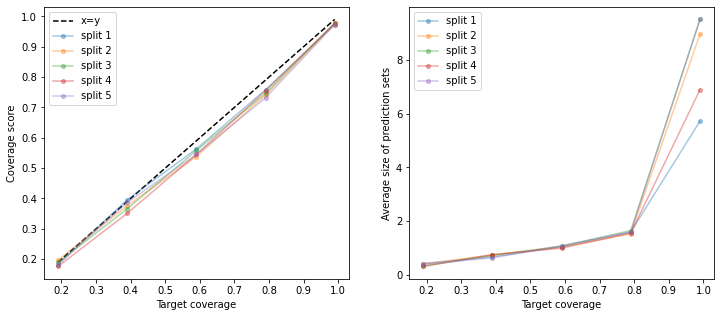

In [6]:
plot_coverages_widths(list_values, initial_coverage, initial_width, method="QR")

Here we can observe that the coverage is most of the time below the target coverage and we can also observe that when the target coverage is high, the quantile regressor seems to give large interval widths. Hence, this makes us wonder how MAPIE will help with the coverage and how on different splits it differs, do we add significantly more on some splits compared to other ones?

We will observe how changing the split has an effect on the quantile values and therefore on the added value by MAPIE.

In [7]:
alphas = [0.4]
list_values, mapie_coverage, interval_width, list_scores = CQR_alphas(alphas=alphas, random_data=False, random_split=True, iters=5)

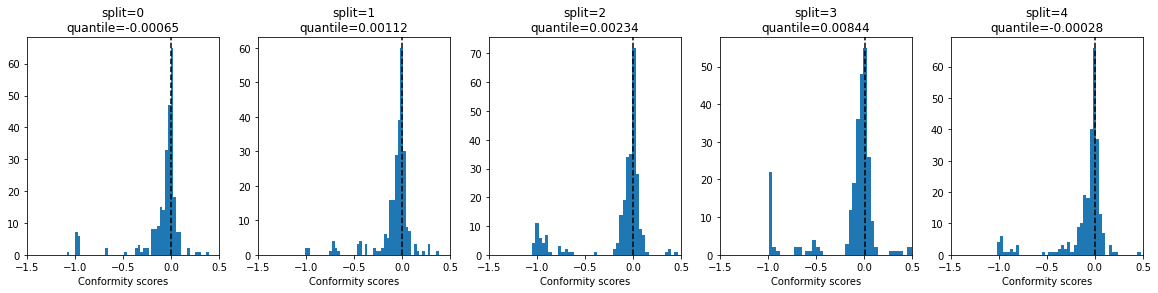

Stats Quantile
Mean:  0.00219
Standard deviation:  0.0033


In [8]:
plot_scores(alphas, list_scores, xlim=(-1.5, 0.5), stats_quantile=True)

We can see from the graph above that it seems that the added value from MAPIE is 

Now we will check how this has an impact on the coverage by looking at five different splits of the dataset and check what happens in each of the splits, how they differ in target vs. realised coverage. 

In [9]:
alphas = np.arange(0.01, 0.99, 0.2)
n_samples = [500, 1000]
list_value, mapie_coverage, mapie_width, _ = CQR_alphas(alphas=alphas, random_data=False, random_split=True, iters=5)

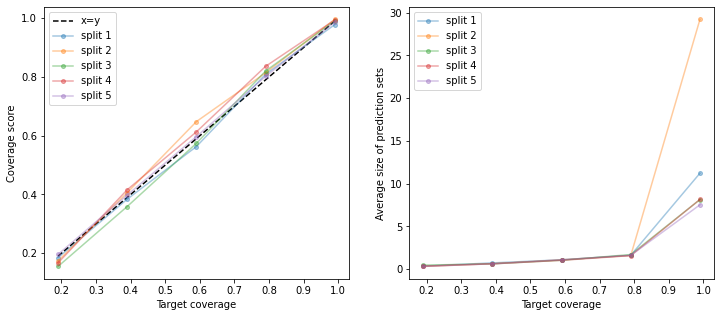

In [10]:
plot_coverages_widths(list_value, mapie_coverage, mapie_width, method="CQR")

We can see that the actual coverage sometimes varies quite a bit  target coverage, the goal would be that they are nearly identical for any alpha. Note that we see that as alpha gets smaller on the graph on the right hand side, the prediction interval seems to shoot up for the last values. 

We will now observe the difference between the target coverage and the actual coverage averaged over all the splits.

In [11]:
alphas = np.arange(0.01, 0.99, 0.2)
n_samples = [500, 1000, 2000, 4000]
list_value, mapie_coverage, mapie_width, _ = CQR_alphas(alphas=alphas, random_data=False, random_split=True, iters=5)
avg_mapie_coverage, avg_mapie_width = np.mean(mapie_coverage, axis=0), np.mean(mapie_width, axis=0)

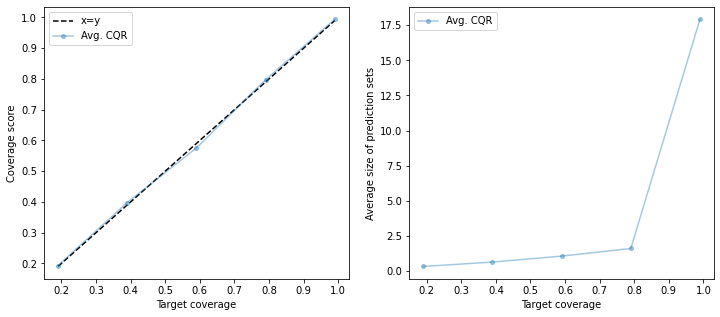

In [12]:
plot_coverages_widths(list_value, avg_mapie_coverage, avg_mapie_width, method="Avg. CQR")

We can see that the target coverage and actual coverage are very close, this is important because it's a key aspect and we see that averaging over the split gives a better performance. This shows that the implementation of a cross-cv would be of benefit. It's interesting to note that we still observe a large increase in prediction interval width as the target coverage gets very high.

Now we want to check how much of the added value compares to the initial added value from the quantile regression. This is to evaluate if we have a quantile regression that is very uncertain or if it's MAPIE that adds a lot of value. The goal is to understand the dynamic between the prediction interval given by QR compared to CQR.

In [13]:
alphas = np.arange(0.01, 0.99, 0.1)
n_samples = np.arange(50, 1000, 50)
list_value, mapie_coverage, mapie_width, list_scores, interval_coverage, interval_width = CQR_alphas(alphas=alphas, random_data=False, random_split=True, iters=5, add_QR=True)

# For alphas
mean_scores = np.mean(list_scores, axis=0)
scores = []
for item in mean_scores:
    scores.append(item[2])

mean_interval_width = np.mean(interval_width, axis=0)

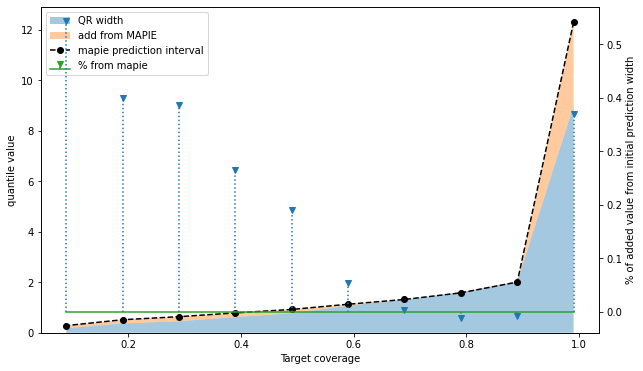

In [14]:
plot_coverage_quantile(list_value, scores, mean_interval_width)

What we observe on this graph is that it would seem that when the target coverage very large or very small MAPIE adds a significantly large value. Interestingly, we observe that when the target coverage is around $0.8 \pm 0.1$, the predictino interval by QR and CQR are relatively similar.

# Direct compararison between QR and CQR

We will set for the different values of alpha that we want to show and put both averages of the plots along the coverage and interval width.

In [15]:
alphas = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.3, 0.45]
list_values, mapie_coverage, mapie_width, _, initial_coverage, initial_width = CQR_alphas(alphas=alphas, random_data=False, random_split=True, iters=5, add_QR=True)
results_alphas = pd.DataFrame(zip(np.array(list_values).flatten(), np.array(initial_coverage).flatten(), np.array(mapie_coverage).flatten(), np.array(initial_width).flatten(), np.array(mapie_width).flatten()), columns=["alphas", "init_cov", "mapie_cov", "init_piw", "mapie_piw"])
results_alphas_ = results_alphas.groupby("alphas").aggregate([np.mean, np.std]).round(3)
results_alphas_ = rename_columns(results_alphas_)
results_alphas_["target_coverage"] = 1 - results_alphas_["alphas_"]
first_column = results_alphas_.pop("target_coverage")
results_alphas_.insert(0, "target_coverage", first_column)

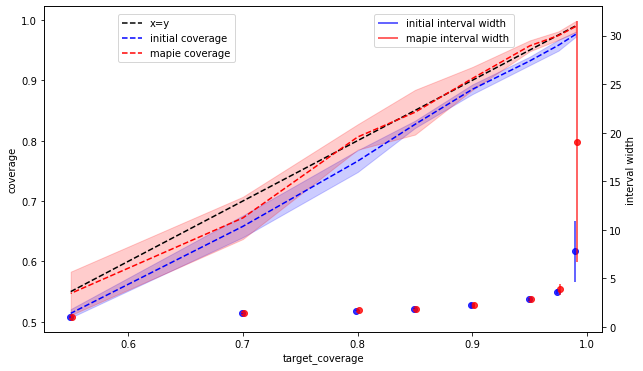

In [16]:
plot_value_vs_cov(results_alphas_)

We can observe that the coverage is much better for MAPIE, nearly perfect. Additionally, we can see that the interval length explodes when the target coverage is high. This is however also a the case for the quantile regression

As we observe that when the target coverage increases, the prediction interval seems to explode, we now want to check if this is a problem of not enought sample. Therefore, while keeping the target coverage constant, we will now iterate over different sample sizes.

In [17]:
n_samples = [100, 250, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 8000, 10000]
list_values, mapie_coverage, mapie_width, _, initial_coverage, initial_width = CQR_alphas(n_samples=n_samples, random_data=False, random_split=True, iters=5, add_QR=True)
results_n_samples = pd.DataFrame(zip(np.array(list_values).flatten(), np.array(initial_coverage).flatten(), np.array(mapie_coverage).flatten(), np.array(initial_width).flatten(), np.array(mapie_width).flatten()), columns=["n_samples", "init_cov", "mapie_cov", "init_piw", "mapie_piw"])
results_n_samples_ = results_n_samples.groupby("n_samples").aggregate([np.mean, np.std]).round(3)
results_n_samples_ = rename_columns(results_n_samples_)


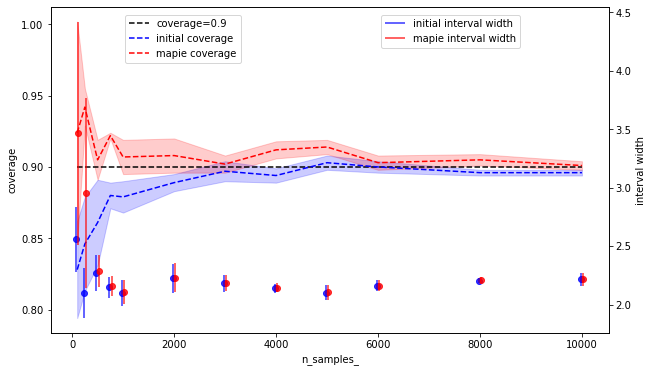

In [18]:
plot_value_vs_cov(results_n_samples_)

Here we can see that the the interval width and coverage seems to be very similar for high sample values ($>1000$). However, when $n\_samples<1000$, we can see that QR does not have a valid coverage and the additional interval length added by CQR seems to make the difference to reach the target coverage.

# USE THE IBM RESAMPLING METHOD TO PUT MORE DATA POINTS ON THE EDGES TO TRY AND GET A MORE CONSTANT PRECICTION